
## Analytics Report:

This report shows a few data mining techniques on a practice data set, the Istanbull Stock Exchange dataset, found at https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE. 

I downloaded the dataset, converted it to a csv file (originally, it was an excel file.) and imported it. One interesting thing about this dataset, because it is a multivariate time series, is that prediction can be done within each day, by regressing all variables for a given day agains one other, or it can be treated as a time series problem, with predictions occurring over windows over time. 

I will split the problem into two parts. Part I will treat EM as the dependent variable, and all the other variables within each day as predictor variables. Then, each date will be a separate training example. Having experimented with this data set, it is enormously hard to produce a good regression estimate. The data set is too noisy. To make this more tractable, the problem will be changed so that the goal is to predict whether EM is above or below it's median value, .00107. To do that, I have converted all EM values above the median to value = 1, and all below 0 to the median to value = 0.

Part II will treat the data as multivariate time series, attempting a similar task, of predicting whether the future value of **EM** will be above or below the median **EM** value for each time point, based upon previous values. This portion of the task will use a recurrent neural network.



## Part I

In [22]:
import pandas as pd
import numpy as np
from collections import Counter
%matplotlib notebook
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


ts_data = pd.read_csv('C:/Users/jws0258/Downloads/data_akbilgic1.csv')
ts_data = ts_data[ts_data['EM'] != 0] #remove instances of EM with missing values
Y_median = np.median(ts_data['EM'])
ts_data['EM'] = np.where(ts_data['EM'] < Y_median, 0, 1)
ts_data.head(4)

,date,ISE_TL,ISE_US,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,1
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,1
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,0
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,0


In [23]:
ts_data.size


5360

Above, I imported the Istanbull Stock Exchange dataset, found at https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE

I downloaded the dataset, converted it to a csv file (originally, it was an excel file.) and imported it.
One interesting thing about this dataset, because it is a multivariate time series, is that prediction can be done within each day, by regressing all variables for a given day agains one other, or it can be treated as a time series problem, with predictions occurring over windows over time. 

For this problem, I will treat **EM** as the dependent variable, and all the other variables within each day as predictor variables. Then, each date will be a separate training example. Having experimented with this data set, it is enormously hard to produce a good regression estimate. The data set is too noisy. To make this more tractable, the problem will be changed so that the goal is to predict whether **EM** is above or below it's median value. To do that, I have converted all **EM** values above the median to value = 1, and all below the median to value = 0.


    

In [182]:
Y_data = ts_data.iloc[:,9]
X_data = ts_data.iloc[:, 1:9]

#rescale X_data to (0,1)
scale = MinMaxScaler(feature_range=(0,1))
X_data = scale.fit_transform(X_data)
X_data = pd.DataFrame(X_data)

test_size = .3
seed = 10
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=test_size, random_state = seed)

In [32]:
X_train.head(2)



,0,1,2,3,4,5,6,7
80,0.379996,0.342466,0.420113,0.302828,0.358842,0.209842,0.457929,0.281590
476,0.567675,0.560398,0.616894,0.706464,0.715844,0.497576,0.661316,0.614829


Above, I split the data into training and testing sets, with 30% of the data randomly assigned to the test set, and 70% to training. as some minor EDA, each variable will be shown as a density plot. 

In [33]:

Counter(Y_train) #count of instances for each class

Counter({0: 182, 1: 193})

<IPython.core.display.Javascript object>


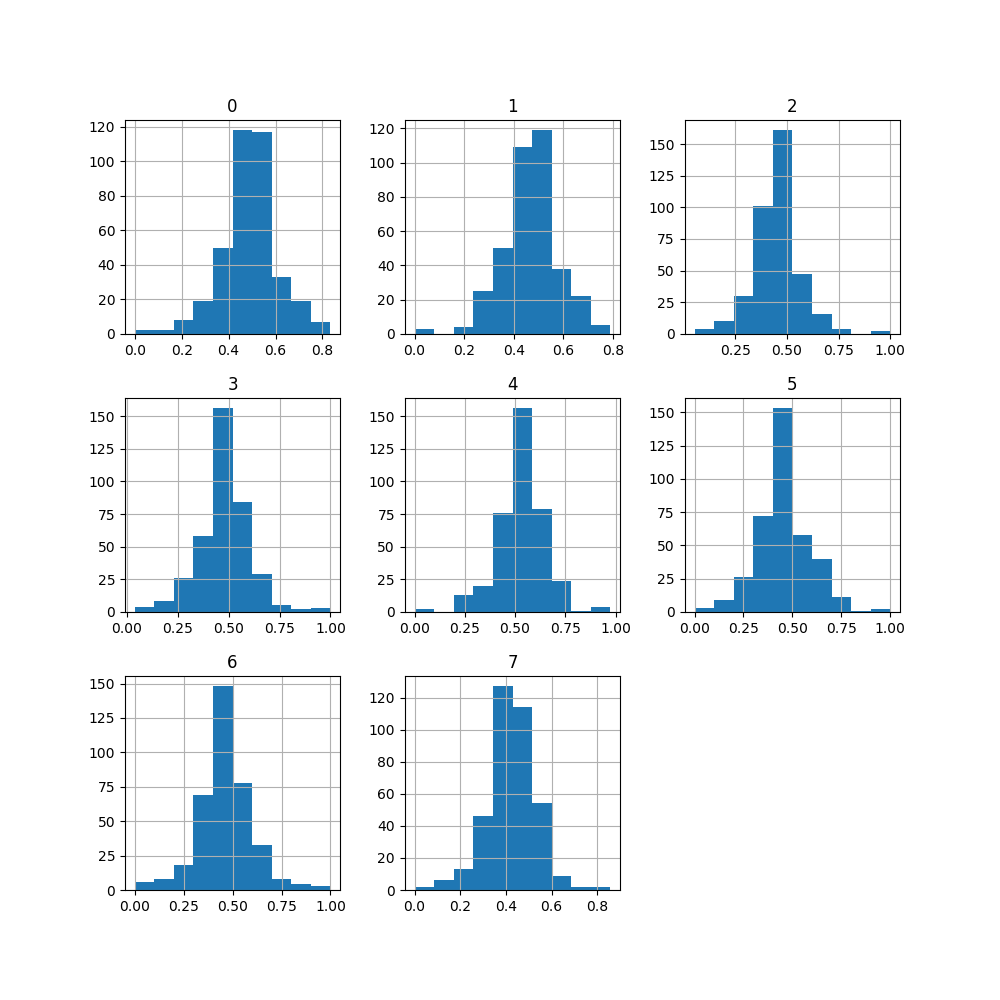

In [34]:
X_train.hist(figsize=(10,10))
plt.show()

These all seem to be approximately symmetric in terms of values, and both skew and kurtosis seem reasonable.

 ## Model Selection
    
For this report, I have chosen four models. Two of them are variants of neural network models. One is an ensemble of support vector machines, each fit to different portions of the data, and one is a random forest model.

One interesting thing about this data set, is that it is likely non-stationary, in that the function that describes the
relationship between the variables likely changes over time. For this reason, ensemble methods are likely to do better than stand alone models. This difference will be explicitly tested with the neural network models.

First, I will use grid search to tune each of the svm hyperparameters, fit, and test the support vector machine models.


In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

#
svm_estimators = 100 #number of estimators to include in model
subset_size = int(round(len(X_train/4)))
svms = []
paramlist = []
predictionlist = []
fitslist = []
scores1 = []  #records R^2 values for fit models.
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], }
#instantiate models
for _ in range(svm_estimators):
    svms.append(SVC(gamma = 15, class_weight='balanced'))


    #parameter tuning and model fitting

    
for i in range(svm_estimators):
    idx = np.random.choice(len(X_train), size = subset_size, replace=True)
    X_subset = X_train.iloc[idx, :]
    Y_subset = Y_train.iloc[idx]
    #tunedsvm = GridSearchCV(svms[i], parameters)
    fits = svms[i].fit(X_subset, Y_subset)
    scores1.append(fits.score(X_subset, Y_subset))
    fitslist.append(fits.predict(X_subset))
    #now, get prediction on entire test set
    predictionlist.append(fits.predict(X_test))
    

print(scores1)


    

[0.872, 0.91466666666666663, 0.8773333333333333, 0.91733333333333333, 0.90133333333333332, 0.872, 0.88533333333333331, 0.89600000000000002, 0.86133333333333328, 0.89066666666666672, 0.93066666666666664, 0.86933333333333329, 0.8666666666666667, 0.872, 0.89600000000000002, 0.89600000000000002, 0.90400000000000003, 0.90133333333333332, 0.92000000000000004, 0.90133333333333332, 0.89866666666666661, 0.91466666666666663, 0.86933333333333329, 0.8746666666666667, 0.89066666666666672, 0.90666666666666662, 0.91200000000000003, 0.91733333333333333, 0.94133333333333336, 0.90666666666666662, 0.89600000000000002, 0.89333333333333331, 0.90666666666666662, 0.90933333333333333, 0.90666666666666662, 0.89066666666666672, 0.90400000000000003, 0.93333333333333335, 0.8773333333333333, 0.90400000000000003, 0.91733333333333333, 0.90933333333333333, 0.872, 0.88, 0.8666666666666667, 0.90933333333333333, 0.89600000000000002, 0.89866666666666661, 0.90666666666666662, 0.90400000000000003, 0.89333333333333331, 0.90

Now, the trained model's $R^2$ values will be shown. For the record, these are enormously better $R^2$ values than what were obtained with treating **EM** as a continuous variable. There, values where near 0 or even slightly negative for this model. Negative $R^2$ values indicate that it is better to take the mean as a prediction. Overall, this indicates that there is a lot of noise in the dataset, or that the predictors are not very strong in terms of the mutual information they share with **EM**.

### SVM Prediction

This will be a simple aggregate model, in that the predictions will be determined by a simple majority vote. The model predictions were done above as a part of the loop. Below, they will simply be counted, and the accuracy metrics will be shown, with binary score features to evaluate the performance.



In [36]:
fitslistpan = pd.DataFrame(fitslist)
fitslistpan.head(15)

,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,1,1,0,1,0,0,0,1,0,1,...,1,0,1,1,0,1,0,1,0,0
1,1,1,0,1,1,0,1,1,1,0,...,0,1,1,1,0,1,0,1,1,1
2,1,0,1,0,0,0,1,0,1,1,...,0,1,0,1,1,0,1,1,0,0
3,1,1,1,0,0,0,1,0,1,0,...,1,0,0,1,0,0,1,0,0,0
4,1,0,0,0,1,0,1,0,1,1,...,0,1,1,1,1,0,1,1,0,1
5,1,0,1,1,1,1,1,1,0,0,...,1,0,0,0,1,1,1,0,0,0
6,1,1,1,1,1,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,1
7,0,1,0,1,1,1,1,0,1,1,...,1,1,0,0,1,0,0,0,0,1
8,1,1,1,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,1,1
9,0,0,0,0,1,1,1,0,1,0,...,1,1,1,0,1,0,1,1,1,1


In [37]:
#predictionlist.head(30)
predictionlist_df = pd.DataFrame(np.transpose(predictionlist))
predictionlist_df.head(15)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,0,1,0,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,0,1
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Model Predictions for 15 of the test samples are shown above. Rows are test data points, and columns are individual model predictions. 

Initially, all outcomes in both the train and test predictions defaulted to all 0's or 1's for each model. In order to prevent this, the gamma parameter needed to be tuned unusually high. It was not until the gamma parameter was set to 15 that there was noticable heterogeneity in predictions from models. This is somewhat worriesome, as it may increase the likelihood of overfitting. As a way of attempting to counterbalance this, a high number of models were used for inference.

In [38]:
aggregate_predictions = predictionlist_df.mean(axis=1)
agg_len = len(aggregate_predictions)
for i in range(agg_len):
    if aggregate_predictions[i] < .5:
        aggregate_predictions[i] = 0
    else:
        aggregate_predictions[i] = 1

In [39]:
from sklearn.metrics import classification_report, roc_auc_score

from IPython.display import display
#display(df)
print(display(classification_report(Y_test, aggregate_predictions)))

'             precision    recall  f1-score   support\n\n          0       0.87      0.79      0.83        86\n          1       0.78      0.87      0.82        75\n\navg / total       0.83      0.83      0.83       161\n'

None


Basic binary scoring metrics are shown above. 

In [40]:
roc_auc_score(Y_test, aggregate_predictions)


0.8286821705426356

 Increasing both the gamma value and the number of model substantially increased the accuracy.
 
 Next, variants of a random forest model will be evaluated on the dataset.

### Random Forest Prediction

There are several different ways to view the data. I will fit models for both the original data, a distance matrix form of the data, as well as adding both the original data and the distance matrix as inputs to see what the differences are in terms of results.

With the original data, all tree splits occur based upon variable values, while with the distance matrix transformation, the distance between covariates are what the tree splits upon.


In [43]:
from sklearn.ensemble import RandomForestClassifier

for i in range(10):
    treenum = 20 + i*10
    rf1 = RandomForestClassifier(random_state=0, n_estimators = treenum)
    rf1.fit(X_train, Y_train)
    rf1_predictions = rf1.predict(X_test)
    print('%s trees' %(treenum),)
    print(classification_report(Y_test, rf1_predictions))



20 trees
             precision    recall  f1-score   support

          0       0.82      0.80      0.81        86
          1       0.78      0.80      0.79        75

avg / total       0.80      0.80      0.80       161

30 trees
             precision    recall  f1-score   support

          0       0.83      0.81      0.82        86
          1       0.79      0.81      0.80        75

avg / total       0.81      0.81      0.81       161

40 trees
             precision    recall  f1-score   support

          0       0.82      0.80      0.81        86
          1       0.78      0.80      0.79        75

avg / total       0.80      0.80      0.80       161

50 trees
             precision    recall  f1-score   support

          0       0.83      0.80      0.82        86
          1       0.78      0.81      0.80        75

avg / total       0.81      0.81      0.81       161

60 trees
             precision    recall  f1-score   support

          0       0.83      0.80      0.8

From the above, accuracy peaks at about 30-60 trees. Given that there are only seven predictor variables, this is understandable. Next, the distance matrix as input will be tried.

In [45]:
import scipy
X_outer = []
X_outer_test = []

for i in range(len(X_test)):
    
    a = np.subtract.outer(X_test.iloc[i,:], X_test.iloc[i,:])
    X_outer_test.append(a.flatten())
    
X_outerpd_test = pd.DataFrame(X_outer_test)


for i in range(len(X_train)):
    
    b = np.subtract.outer(X_train.iloc[i,:], X_train.iloc[i,:])
    X_outer.append(b.flatten())
    
X_outerpd = pd.DataFrame(X_outer)
X_outerpd.shape
X_outerpd.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.037530,-0.040117,0.077168,0.021154,0.170154,-0.077934,0.098406,-0.037530,0.0,...,0.0,0.176339,-0.098406,-0.060876,-0.138523,-0.021238,-0.077252,0.071748,-0.176339,0.0
1,0.0,0.007277,-0.049219,-0.138789,-0.148169,0.070099,-0.093641,-0.047154,-0.007277,0.0,...,0.0,0.046487,0.047154,0.054432,-0.002065,-0.091634,-0.101014,0.117253,-0.046487,0.0
2,0.0,0.057853,0.138927,0.091956,0.008159,0.128859,0.139195,0.151072,-0.057853,0.0,...,0.0,0.011877,-0.151072,-0.093219,-0.012145,-0.059116,-0.142913,-0.022214,-0.011877,0.0
3,0.0,0.047455,0.042020,0.078654,-0.031757,0.117295,-0.017403,0.087786,-0.047455,0.0,...,0.0,0.105189,-0.087786,-0.040331,-0.045766,-0.009132,-0.119543,0.029509,-0.105189,0.0
4,0.0,-0.011927,0.029457,-0.041268,-0.088386,-0.000702,-0.062442,0.028511,0.011927,0.0,...,0.0,0.090954,-0.028511,-0.040438,0.000946,-0.069779,-0.116898,-0.029213,-0.090954,0.0


In [46]:
for i in range(10):
    treenum = 20 + i*10
    rf2 = RandomForestClassifier(random_state=0, n_estimators = treenum)
    rf2.fit(X_outerpd, Y_train)
    rf2_predictions = rf2.predict(X_outerpd_test)
    print('%s trees' %(treenum),)
    print(display(classification_report(Y_test, rf2_predictions)))


20 trees


'             precision    recall  f1-score   support\n\n          0       0.67      0.65      0.66        86\n          1       0.62      0.64      0.63        75\n\navg / total       0.65      0.65      0.65       161\n'

None
30 trees


'             precision    recall  f1-score   support\n\n          0       0.68      0.63      0.65        86\n          1       0.61      0.67      0.64        75\n\navg / total       0.65      0.65      0.65       161\n'

None
40 trees


'             precision    recall  f1-score   support\n\n          0       0.68      0.62      0.65        86\n          1       0.60      0.67      0.63        75\n\navg / total       0.64      0.64      0.64       161\n'

None
50 trees


'             precision    recall  f1-score   support\n\n          0       0.67      0.59      0.63        86\n          1       0.59      0.67      0.62        75\n\navg / total       0.63      0.63      0.63       161\n'

None
60 trees


'             precision    recall  f1-score   support\n\n          0       0.68      0.60      0.64        86\n          1       0.60      0.67      0.63        75\n\navg / total       0.64      0.63      0.63       161\n'

None
70 trees


'             precision    recall  f1-score   support\n\n          0       0.68      0.60      0.64        86\n          1       0.60      0.67      0.63        75\n\navg / total       0.64      0.63      0.63       161\n'

None
80 trees


'             precision    recall  f1-score   support\n\n          0       0.67      0.60      0.63        86\n          1       0.59      0.65      0.62        75\n\navg / total       0.63      0.63      0.63       161\n'

None
90 trees


'             precision    recall  f1-score   support\n\n          0       0.68      0.63      0.65        86\n          1       0.61      0.67      0.64        75\n\navg / total       0.65      0.65      0.65       161\n'

None
100 trees


'             precision    recall  f1-score   support\n\n          0       0.68      0.60      0.64        86\n          1       0.60      0.68      0.64        75\n\navg / total       0.64      0.64      0.64       161\n'

None
110 trees


'             precision    recall  f1-score   support\n\n          0       0.68      0.60      0.64        86\n          1       0.60      0.67      0.63        75\n\navg / total       0.64      0.63      0.63       161\n'

None


The random forest using the distance matrix all scored worse overall. There are other variations that could have been performed, such as applying a kernel distance measure.



### Feed Forward Neural Networks

The final model type to be used for trying to predict **EM** being above or below it's mean is a neural network. Because there is unlikely to be proximity based correlation, like there would be for images or time series data, a densely connected model will be used. Several variations will be tried, and, like the support vector machine models, a random subspace aggregate model will be used as well. Like decision trees and support vector machines, neural networks are typically low bias/high variance models in terms of statistical error. This makes them good candidates for aggregate modeling techniques. Additionally, since there are only seven predictor variables, and a dense net is being used, no single model will take incredibly long to process, making aggregate methods more pragmatic to use in this case versus situations where larger models are needed. 

The base model class is shown below. Keras models can be instantiated and treated like a class, so it is relatively easy to create many different variants of models. If more portability, or additional, custom objects are desired to be stored for each model, a class can be built around a keras model instantiation.

In [47]:
# keras.models import 
from keras.models import load_model, Model
from keras.layers import Input, Dense, Activation
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam
from sklearn import preprocessing

def Keras_model1():
    Input1 = Input(shape=(8,))
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.001))(Input1)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.001))(x)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.001))(x)
    out = Dense(1, activation = 'sigmoid', kernel_regularizer=l2(.001))(x)
    model = Model(inputs= Input1, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



Using TensorFlow backend.


First, a single model of the above will be instantiated, trained, and tested, in order to see how it performs.


Validation Loss after final iteration:  0.472479715851


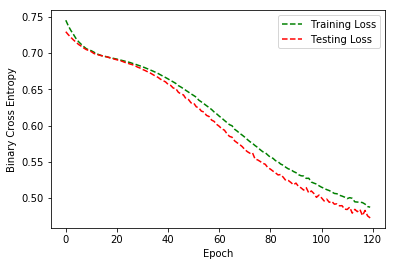

In [183]:
%matplotlib inline

baseline_mod = Keras_model1()
base_fit = baseline_mod.fit(X_train, Y_train, epochs = 120, verbose = 0, validation_data=(X_test, Y_test))

plt.plot(base_fit.history['loss'], 'g--')
plt.plot(base_fit.history['val_loss'], 'r--')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
print("Validation Loss after final iteration: ", base_fit.history['val_loss'][-1])
plt.show()

While there were many models not tested, RELU activation units with .001 L2 regularization seemed to work well. Wider intermediate layers tended to overfit much easier, having much higher validation loss even with higher L2 regularization.

Next, two neural network models will be used. Given the size of the dataset, these will be smaller models. One promising alternative to the below would be to pretrain a model on similar time series data, and then fine tune on this dataset.

In [65]:
nn_estimators = 15
subset_size = int(round(len(X_train)/4))
nn_predictionlist = []
def Keras_model2():
    Input1 = Input(shape=(8,))
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.002))(Input1)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.002))(x)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.002))(x)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(.002))(x)
    out = Dense(1, activation = 'sigmoid', kernel_regularizer=l2(.002))(x)
    model = Model(inputs= Input1, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def Keras_model3():
    Input1 = Input(shape=(8,))
    x = Dense(4, activation = 'sigmoid', kernel_regularizer=l2(.2))(Input1)
    x = Dense(4, activation = 'sigmoid', kernel_regularizer=l2(.2))(x)
    
    out = Dense(1, activation = 'sigmoid', kernel_regularizer=l2(.2))(x)
    model = Model(inputs= Input1, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model  #sigmoid activation units produce poor performance very easily with increased layers, 
                  #so depth was reduced.



model2 = Keras_model2()
model3= Keras_model3()
model2.fit(X_train, Y_train, epochs = 120, verbose = 0)
model3.fit(X_train, Y_train, epochs = 70, verbose = 0)
    
    


In [60]:
model2_predictions = model2.predict(X_test)
model2_predictions_binary = np.where(model2_predictions < .5, 0, 1)

#print(model2_predictions_binary)
print(classification_report(Y_test, model2_predictions_binary))

             precision    recall  f1-score   support

          0       0.88      0.80      0.84        86
          1       0.80      0.88      0.84        75

avg / total       0.84      0.84      0.84       161



This scored much higher than either of the previous models used. Next, the feed forward neural network with sigmoid activation functions will be shown.

In [66]:
model3_predictions = model3.predict(X_test)
model3_predictions_binary = np.where(model3_predictions < .5, 0, 1)


print(classification_report(Y_test, model3_predictions_binary))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        86
          1       0.47      1.00      0.64        75

avg / total       0.22      0.47      0.30       161



C:\Users\jws0258\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The above model is essentially unusable for this dataset. More regularization or less layers should be used in order to obtain effective results.

Having built the aggregate model for neural networks, the accuracy will be shown.



In [67]:
from sklearn.metrics import classification_report, roc_auc_score


print(classification_report(Y_test, raw_predictions))



             precision    recall  f1-score   support

          0       0.89      0.77      0.82        86
          1       0.77      0.89      0.83        75

avg / total       0.84      0.83      0.83       161



The precision is much higher for this model than it was for the other models. The accuracy was not as high in comparison to the random forest or aggregate support vector machine models.

In [54]:
roc_auc_score(Y_test, raw_predictions)


0.83038759689922481

Overall, the auc score was very slightly higher for the random forest, although neural networks and random forests were both very close in comparison. Using the roc_auc_score as the comparative metric, Random forests, followed by the aggregate neural networks, followed by the aggregate support vector machine model did the best in terms of performance on this dataset. 

## Part II: Treating Data as a time series



First, the data will be windowed, so that each predictor will consist of values for five time points previous to the date of prediction, t, and the dependent variable will be whether **EM** at time t is above or below the median value for **EM**, as like the previous section's models. Pandas makes this pretty straight forward. The length of the lookback window is fairly arbitrary, but should offer an example of some basic modeling techniques, where there is expected to be some correlation over time. This is not a long time series, as set up here, so a convolutional network would likely be more efficient, but it was desired to see what a recurrent, lstm based model could do on this dataset.

In [141]:



def windower(data, lookback): #assumes pandas df input, for creating dataset
    
    
    ts_num = len(data) - (lookback + 1)
    X_w = []
    Y_w = []
    
    for i in range(ts_num):
        X_dat = np.asarray(data.iloc[i:i+lookback, 1:9])
        Y_dat = np.asarray(data.iloc[i+lookback:i+lookback+1, 9])
        X_w.append(X_dat)    
        Y_w.append(Y_dat)
    return X_w, Y_w
        
    
X_w, Y_w = windower(ts_data, 5)
X_w1 = np.dstack(X_w)
Y_w1 = np.dstack(Y_w)

print(np.shape(X_w1))
print(np.shape(Y_w1))

(5, 8, 530)
(1, 1, 530)


In [184]:
X_w, Y_w = windower(ts_data, 5)
X_w1 = np.dstack(X_w)
Y_w1 = np.dstack(Y_w)
X_w2 = np.swapaxes(X_w1, 0, 2) #have to transpose axis
Y_w2 = np.swapaxes(Y_w1, 0, 2)
X_w2 = np.swapaxes(X_w2, 1, 2)
Y_w2 = np.swapaxes(Y_w2, 1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_w2, Y_w2, test_size=0.33, random_state=42)

#X_w_a = np.asarray(X_w)
#np.shape(X_w_a)
y_train1 = y_train.flatten()
y_test1 = y_test.flatten()
X_train.shape


(355, 5, 8)

Having windowed the data, and split the samples into training and testing sets, a few examples of model performance will be shown. This is not a big data set, with only 355 samples in the training set, so models will tend to be on the smaller side as to not overfit. First, the RNN model will be shown. 

Train on 355 samples, validate on 175 samples
Epoch 1/16
355/355 [==============================] - 4s 10ms/step - loss: 2.2603 - acc: 0.4901 - val_loss: 1.8413 - val_acc: 0.5143
Epoch 2/16
355/355 [==============================] - 0s 232us/step - loss: 1.8052 - acc: 0.4901 - val_loss: 1.5983 - val_acc: 0.5143
Epoch 3/16
355/355 [==============================] - 0s 237us/step - loss: 1.5787 - acc: 0.4901 - val_loss: 1.3882 - val_acc: 0.5143
Epoch 4/16
355/355 [==============================] - 0s 189us/step - loss: 1.3781 - acc: 0.4901 - val_loss: 1.2345 - val_acc: 0.5143
Epoch 5/16
355/355 [==============================] - 0s 214us/step - loss: 1.2226 - acc: 0.4901 - val_loss: 1.0960 - val_acc: 0.5143
Epoch 6/16
355/355 [==============================] - 0s 244us/step - loss: 1.0815 - acc: 0.4901 - val_loss: 0.9641 - val_acc: 0.5143
Epoch 7/16
355/355 [==============================] - 0s 232us/step - loss: 0.9541 - acc: 0.4901 - val_loss: 0.8603 - val_acc: 0.5143
Epoch 8/16
355/35

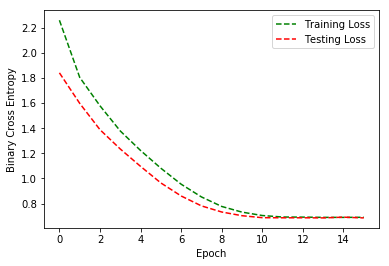

In [179]:
from keras.layers import Embedding, LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation


model_lstm = Sequential()
model_lstm.add(LSTM(8, input_shape=(5, 8)))
model_lstm.add(Dense(1), )

model_lstm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
lstm_mod = model_lstm.fit(X_train, y_train1, epochs=16, validation_data = (X_test, y_test1))


%matplotlib inline


plt.plot(lstm_mod.history['loss'], 'g--')
plt.plot(lstm_mod.history['val_loss'], 'r--')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
print("Validation Loss after final iteration: ", lstm_mod.history['val_loss'][-1])
plt.show()

From the above, it can be seen that both training and testing accuracy stop improving after approximately 11 epochs. So, for the model used for verification, a model with 11 epochs will be used.

In [195]:
model_lstm = Sequential()
model_lstm.add(LSTM(4, input_shape=(5, 8)))
model_lstm.add(Dense(1, kernel_regularizer=l2(.05)))

model_lstm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
lstm_mod = model_lstm.fit(X_train, y_train1, epochs=11, validation_data = (X_test, y_test1))
lstm_predictions = model_lstm.predict(X_test)
lstm_predictions_binary = np.where(model3_predictions < .5, 0, 1)

print(classification_report(Y_test, lstm_predictions_binary))


Train on 355 samples, validate on 175 samples
Epoch 1/11
355/355 [==============================] - 4s 12ms/step - loss: 2.5594 - acc: 0.4901 - val_loss: 2.0451 - val_acc: 0.5143
Epoch 2/11
355/355 [==============================] - 0s 228us/step - loss: 2.0210 - acc: 0.4901 - val_loss: 1.8234 - val_acc: 0.5143
Epoch 3/11
355/355 [==============================] - 0s 274us/step - loss: 1.8175 - acc: 0.4901 - val_loss: 1.6468 - val_acc: 0.5143
Epoch 4/11
355/355 [==============================] - 0s 339us/step - loss: 1.6465 - acc: 0.4901 - val_loss: 1.5054 - val_acc: 0.5143
Epoch 5/11
355/355 [==============================] - 0s 260us/step - loss: 1.5080 - acc: 0.4901 - val_loss: 1.3745 - val_acc: 0.5143
Epoch 6/11
355/355 [==============================] - 0s 226us/step - loss: 1.3752 - acc: 0.4901 - val_loss: 1.2485 - val_acc: 0.5143
Epoch 7/11
355/355 [==============================] - 0s 294us/step - loss: 1.2534 - acc: 0.4901 - val_loss: 1.1509 - val_acc: 0.5143
Epoch 8/11
355/35

C:\Users\jws0258\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
print(lstm_predictions_binary)

The LSTM model had quite a bit of trouble, and was not a reliable model for this particular data set. Changing the window length of the time series most likely would have imporoved the score. Conversely, a convolutional network may have been a better choice, given how noisy the dataset is, and how short the time window was. 

### Conclusions:

Overall, the bagged svm models performed the best in terms of accuracy, while the Relu activation based feedforward network scored the best in terms of precision. The recurrent neural network was not performative, neither was the feedforward network based upon sigmoid activation units in the intermediate layer. For both of the worst performing models, one common underlying issue is that both models can struggle to handle very noisy data. In fact, given the success of the bagged svm models and the Relu based neural network, which also had strong regularization applied, dealing with statistical noise among the predictors seems to be the major obstacle for this dataset, and models that deal with noise well are likely to perform the best.

